In [99]:
#pip install ipywidgets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
import keras
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler


In [100]:
df = pd.read_csv("gld_price_data.csv")
df.head()

,Date,SPX,GLD,USO,SLV,EUR/USD
0,1/2/2008,1447.160034,84.860001,78.470001,15.180,1.471692
1,1/3/2008,1447.160034,85.570000,78.370003,15.285,1.474491
2,1/4/2008,1411.630005,85.129997,77.309998,15.167,1.475492
3,1/7/2008,1416.180054,84.769997,75.500000,15.053,1.468299
4,1/8/2008,1390.189941,86.779999,76.059998,15.590,1.557099


There are no missing values, and there is a gap on every weekend. But because the stock market is closed on weekends, I don't consider these as "gaps", as the data is sequential and there is no change to the exchange rates on Saturday and Sunday.

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     2290 non-null   object 
 1   SPX      2290 non-null   float64
 2   GLD      2290 non-null   float64
 3   USO      2290 non-null   float64
 4   SLV      2290 non-null   float64
 5   EUR/USD  2290 non-null   float64
dtypes: float64(5), object(1)
memory usage: 107.5+ KB


In [102]:
df.describe

<bound method NDFrame.describe of            Date          SPX         GLD        USO      SLV   EUR/USD
0      1/2/2008  1447.160034   84.860001  78.470001  15.1800  1.471692
1      1/3/2008  1447.160034   85.570000  78.370003  15.2850  1.474491
2      1/4/2008  1411.630005   85.129997  77.309998  15.1670  1.475492
3      1/7/2008  1416.180054   84.769997  75.500000  15.0530  1.468299
4      1/8/2008  1390.189941   86.779999  76.059998  15.5900  1.557099
...         ...          ...         ...        ...      ...       ...
2285   5/8/2018  2671.919922  124.589996  14.060000  15.5100  1.186789
2286   5/9/2018  2697.790039  124.330002  14.370000  15.5300  1.184722
2287  5/10/2018  2723.070068  125.180000  14.410000  15.7400  1.191753
2288  5/14/2018  2730.129883  124.489998  14.380000  15.5600  1.193118
2289  5/16/2018  2725.780029  122.543800  14.405800  15.4542  1.182033

[2290 rows x 6 columns]>

In [103]:
value_column = "GLD"
scaler = MinMaxScaler()
df[[value_column]] = scaler.fit_transform(df[[value_column]])

drop_first_columns = 1800
df = df[[value_column]][drop_first_columns:]
df["sequence"] = df.index - drop_first_columns + 1
df

,GLD,sequence
1800,0.418187,1
1801,0.411118,2
1802,0.424470,3
1803,0.416878,4
1804,0.424819,5
...,...,...
2285,0.476394,486
2286,0.474125,487
2287,0.481543,488
2288,0.475521,489


In [104]:
# let's figure out a good cutoff point for train/test
# 67% for training, 33% testing (NOTE: you should experiment on this to find optimal %)
cutoff = int(len(df) * 0.75)

# train data
X_train = df.index[0:cutoff]
y_train = df[value_column].iloc[0:cutoff]

# test data
X_test = df.index[cutoff:]
y_test = df[value_column].iloc[cutoff:]

# convert everything into NumPy -array format
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# in this case, number of variables is 1 => scaled passengers value
n_features = 1

# use reshape tools to get the data ready for future use
train_series = y_train.reshape((len(y_train), n_features))
test_series  = y_test.reshape((len(y_test), n_features))
train_series

array([[0.41818658],
       [0.41111792],
       [0.42446986],
       [0.41687755],
       [0.42481893],
       [0.44270883],
       [0.44105073],
       [0.44628677],
       [0.44139981],
       [0.43267304],
       [0.44942841],
       [0.43118951],
       [0.41775028],
       [0.41853565],
       [0.44148702],
       [0.43747272],
       [0.43459294],
       [0.42726242],
       [0.43031678],
       [0.40675454],
       [0.40431105],
       [0.40666725],
       [0.42551709],
       [0.41103063],
       [0.41574309],
       [0.40274024],
       [0.41591767],
       [0.40963438],
       [0.42420807],
       [0.43660006],
       [0.43677463],
       [0.42560432],
       [0.41111792],
       [0.41661576],
       [0.43267304],
       [0.42734971],
       [0.43127672],
       [0.42089192],
       [0.42499344],
       [0.42796058],
       [0.4475958 ],
       [0.46461297],
       [0.46216948],
       [0.45562441],
       [0.45440267],
       [0.44201068],
       [0.44489052],
       [0.454

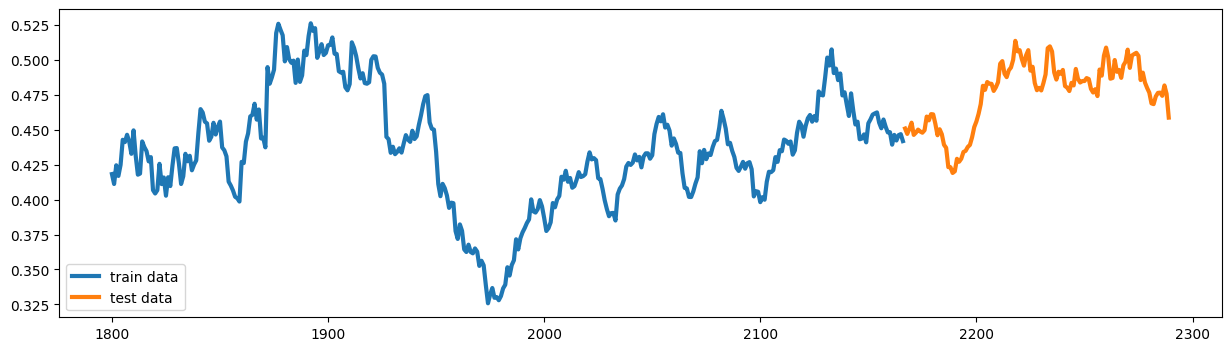

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(X_train,y_train, lw=3, label='train data')
ax.plot(X_test, y_test,  lw=3, label='test data')
ax.legend(loc="lower left")
plt.show()

In [106]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# the variable that determines how many points
# back into the past the model attempts to learn
look_back  = 12
batch_size = 1

# stride = 1 => means we use separate time steps
# more than 1 => we use windowing

# TimeseriesGenerators were deprecated by TensorFlow developers
# during October 2024
# this means, in some unknown future TensorFlow -version
# this feature will removed
# check the other version of this notebook on how to replace
# TimeseriesGenerator with a TensorFlow Dataset
train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = batch_size)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = batch_size)

In [107]:
from keras.models import Sequential
from keras import Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

# create a model checkpoint to a file, and only save the best one
mc = ModelCheckpoint('best_model_flights.keras', monitor='val_loss', mode='min', save_best_only=True)
callback_list = [mc]

# build the neural network
# in this case, LSTM with 8 neurons
n_neurons  = 64

model = Sequential()
model.add(Input(shape=(look_back, n_features)))
model.add(SimpleRNN(n_neurons, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

initial_weights = model.get_weights()

# it's not optimal to use test data as validation data
# because this might skew our metrics
# see the other version of this notebook on how to do
# train/validation/test -split for the sine wave
model.fit(train_generator, epochs=200, verbose=1, validation_data=test_generator, callbacks=callback_list)


Epoch 1/200


c:\Users\zsolt\OneDrive - Óbudai egyetem\Deep Learning\deeplearning\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


355/355 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0027 - val_loss: 2.1933e-04
Epoch 2/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.4857e-04 - val_loss: 1.0694e-04
Epoch 3/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.7548e-04 - val_loss: 1.1061e-04
Epoch 4/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.2680e-04 - val_loss: 4.4572e-04
Epoch 5/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.2523e-04 - val_loss: 8.6197e-05
Epoch 6/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.2754e-04 - val_loss: 9.2260e-05
Epoch 7/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.4729e-04 - val_loss: 3.4666e-04
Epoch 8/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.8646e-04 - val_loss: 1.3016e-04
Epoch 9/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.8514e-04 - val_loss: 1.5616e-04
Epoch 10/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.7089e-04 - val_loss: 6.5115e-05
Epoch 11/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.5

<Axes: >

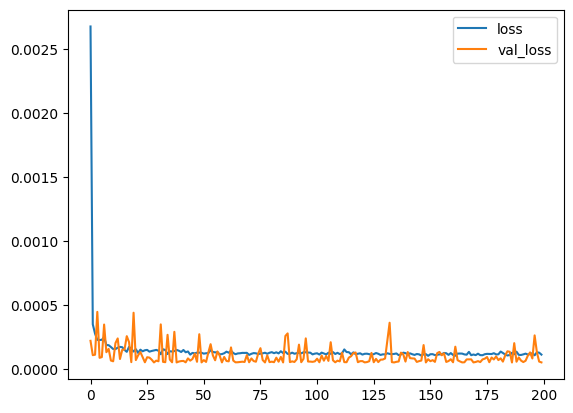

In [108]:
# the usual training metrics visualization
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [118]:
# training accuracy?

In [119]:
# reload the best version of the model
from keras.models import load_model
model = load_model("best_model_flights.keras")

In [120]:
# TensorFlow evaluation metrics
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

# test loss
result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

# these values are very close to each other, 
# which means our model is quite optimal
# IN THEORY 

355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.5515e-05
Training loss: 8.5515457612928e-05
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9875e-05
Testing loss: 4.987511783838272e-05


In [121]:
test_predictions  = model.predict(test_generator)

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [122]:
# let's make a separate copy of the test values
# so we can calculate some errors

actual_y_test = np.concatenate([y for x, y in test_generator])
errors = np.abs(actual_y_test - test_predictions)
mape = mean_absolute_percentage_error(actual_y_test, test_predictions) * 100

# print out the MAPE-score
print("MAPE (mean average precision error):")
print(f"{round(mape, 2)} %")

# MAE - Mean average error
print("\nMAE")
print(round(metrics.mean_absolute_error(actual_y_test, test_predictions), 2), "units")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(actual_y_test, test_predictions), 2), "units^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(actual_y_test, test_predictions)), 2), "units")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(actual_y_test, test_predictions), 2))

MAPE (mean average precision error):
1.14 %

MAE
0.01 units

MSE
0.0 units^2

RMSE:
0.01 units

R-squared:
0.9


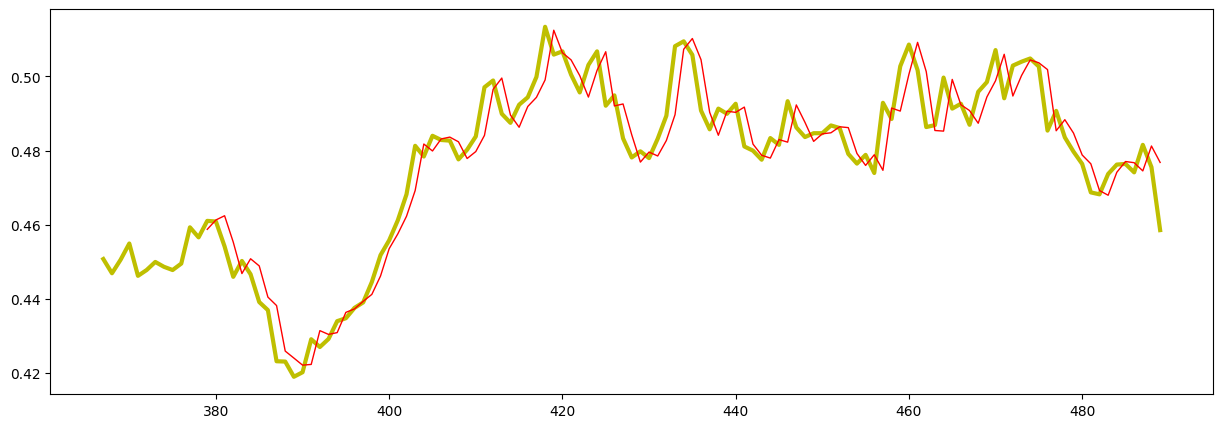

In [123]:
# calculate helper x-variables for where the train data starts
# where the test data starts and where the predictions start
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(y_test))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# ax.plot(x1, y_train, lw=2, label='train data')
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, test_predictions, lw=1, c='r', label='predictions')
# ax.legend(loc="lower left")
plt.show()

In [124]:
# TensorFlow evaluation metrics
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

# test loss
result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

# some difference here which we can see in the test-signal prediction already 

355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.5515e-05
Training loss: 8.5515457612928e-05
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9875e-05
Testing loss: 4.987511783838272e-05


In [125]:
# EXTRAPOLATION TEST 1 - 180 new points
extrapolation = list()
seed_batch    = y_test[:look_back].reshape((1,look_back, n_features))
current_batch = seed_batch

# extrapolate the next 180 values
for i in range(120):
    predicted_value = model.predict(current_batch, verbose=None)[0]
    extrapolation.append(predicted_value) 
    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

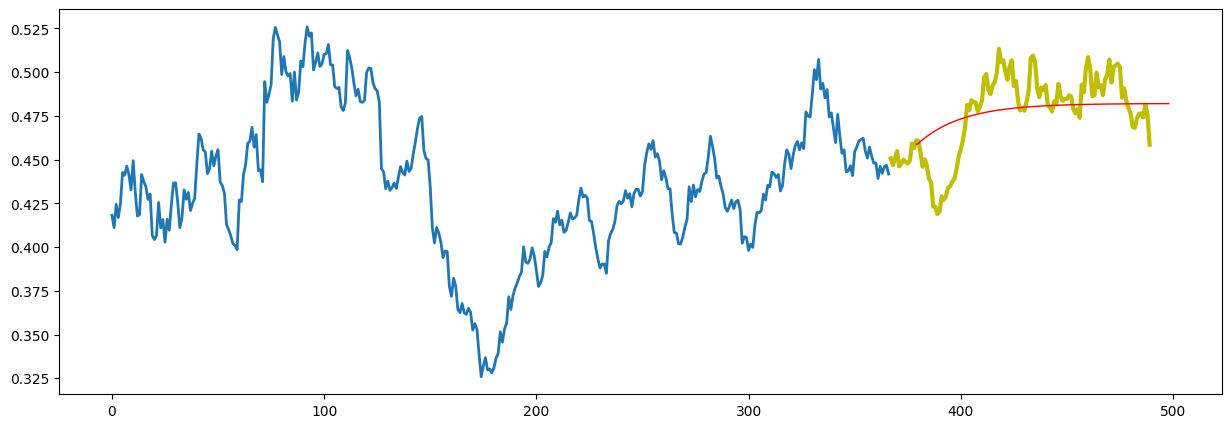

In [126]:
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(extrapolation) + look_back)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x1, y_train, lw=2, label='train data')
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, extrapolation, lw=1, c='r', label='predictions')
# ax.legend(loc="lower left")
plt.show()